# Imports

In [1]:
from sklearn.neighbors import LocalOutlierFactor # not used
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
from scipy.io import arff
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import struct # not used
import graphviz

# Definitions

In [2]:
def k_mean(K, dataset, title="K-Mean Cluster Plot", xLabel=None, yLabel=None):
    """
    Performs K clusters with K-mean on the given dataset and shows the scatter plot afterwards.
    
    @param int K: number of clusters
    @param DataFrame dataset: dataframe of the data to perform k-mean on
    @param str title: what the title of the plot is.
    """
    k_model = KMeans(n_clusters=K)       # get new kmean model with number of clusters = K
    k_model.fit(dataset)                 # fit the data set with the model
    y_pred = k_model.predict(dataset)    # get y predictor from the dataset
    centroids = k_model.cluster_centers_ # get the centroids
    for i in centroids:
        print(i)
    
    %matplotlib inline
    plt.rcParams.update({'font.size': 20})
#     plt.figure(figsize=(5,5))                                                       # set figure size to (12,12)
    plt.scatter(dataset.iloc[:,0], dataset.iloc[:,1], marker='o', alpha=1, c=y_pred)  # scatter data points
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=200, linewidths=2)      # scatter centoids
    plt.xlabel(dataset.columns.values[0] if xLabel==None else xLabel)                 # set x-axis label
    plt.ylabel(dataset.columns.values[1] if yLabel==None else yLabel)                 # set y-axis label
    plt.title(title)                                                                  # set title
    plt.show()                                                                        # show plot

In [ ]:
def k_mean3D(K, dataset, title="K-Mean Cluster 3D Plot", xLabel=None, yLabel=None, zLabel=None):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    k_model = KMeans(n_clusters=K)
    k_model.fit(dataset)
    y_pred = k_model.predict(dataset)
    centroids = k_model.cluster_centers_

    plt.rcParams.update({'font.size': 15})
    ax.scatter(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], marker='o', c=y_pred)
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='x', s=200, linewidths=2)
    ax.set_xlabel(dataset.columns.values[0] if xLabel==None else xLabel)
    ax.set_ylabel(dataset.columns.values[1] if yLabel==None else yLabel)
    ax.set_zlabel(dataset.columns.values[2] if zLabel==None else zLabel)
    plt.title(title)
    plt.show()

In [ ]:
def k_nn(dataset, target, label, title="K-Near Neighbor", yLabel=None):
    """
    Perform K-NN on the given dataset with a target and the given label for data.
    
    @param DataFrame dataset: dataframe of the data to perform K-NN on.
    @param str target: what column is the target variable in the dataset.
    @param str label: what column is the label in the dataset.
    """
    df = dataset.drop([label], axis=1)               # get dataset without label
    var = preprocessing.LabelEncoder()               # set var to hold 
    labelEncoder = var.fit_transform(dataset[label])
    model = KNeighborsClassifier(n_neighbors = 3)
    knn = KNeighborsClassifier(n_neighbors = 5)
    
    model.fit(dataset[[target]], labelEncoder)
    predicted = model.predict([[0]])
    xTrain, xTest, yTrain, yTest = train_test_split(df, dataset[label], test_size = 0.3, random_state=42)
    knn.fit(xTrain, yTrain)
    yPred = knn.predict(xTest)
    
    labels, counts = np.unique(yPred, return_counts=True)
    percents = []
    _sum = sum(counts)
    for i in counts:
        percents.append(i/_sum)

    %matplotlib inline
    plt.rcParams.update({'font.size': 20})
    plt.pie(percents, labels=labels, autopct='%1.1f%%', color=['red', 'blue'])
    plt.title(title)
    plt.show()

In [ ]:
def decision_tree(dataset, target, label, title="Decision Tree"):
    df = dataset.drop([label], axis=1)
    var = tree.DecisionTreeClassifier()
    var = var.fit(df[:13], df[target][:13])
    
    dot_data = tree.export_graphviz(var, out_file=None, 
                                    feature_names=df.columns,
                                    class_names=dataset[label],  
                                    filled=True, rounded=True,
                                    special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [ ]:
# decision_tree(kddDF[['src_bytes','count', 'Class']], "src_bytes", "Class", "DoS")

In [ ]:
def swarm_all(dataset, X, title = "Swarm Plot"):
    df = dataset.drop([X], axis=1)
    for i in df.columns:
        plt.rcParams.update({'font.size': 20})
        sns.swarmplot(x=X, y=i, data=dataset)
        plt.title(title)
        plt.show()

In [ ]:
def find_k_graph(kTests, data, title="Selecting K with the Elbow Method"):
    # k-means cluster analysis
    clusters=range(1,kTests+1)
    meandist=[]
    
    for k in clusters:
        model=KMeans(n_clusters=k)
        model.fit(data)
        clusassign=model.predict(data)
        meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    # Identify number of clusters
    %matplotlib inline
    plt.rcParams.update({'font.size': 20})
    plt.plot(clusters, meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.title(title)
    plt.show()

# NSL-KDD Dataset

<u><strong>Load NSL-KDD dataset<strong></u>

In [3]:
kddFile = arff.loadarff('KDDTrain+.arff')
kddDF = pd.DataFrame(kddFile[0])
kddDF = kddDF.assign(Class=kddDF['class'].apply(lambda x: x.decode('utf-8')))
kddDF = kddDF.drop(['class'], axis=1)
kddDF = kddDF.assign(logged_in=kddDF['logged_in'].apply(lambda x: float(x.decode('utf-8'))))
kddDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0.0,b'tcp',b'ftp_data',b'SF',491.0,0.0,b'0',0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,b'udp',b'other',b'SF',146.0,0.0,b'0',0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,b'tcp',b'private',b'S0',0.0,0.0,b'0',0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,b'tcp',b'http',b'SF',232.0,8153.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,b'tcp',b'http',b'SF',199.0,420.0,b'0',0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
kddDF.describe()

In [ ]:
kddDF.shape

<u><strong>Finding K<strong></u>

In [ ]:
find_k_graph(10, kddDF[['src_bytes', 'count']], "DoS")
find_k_graph(10, kddDF[['duration','src_bytes']], "Probing")
find_k_graph(10, kddDF[['num_file_creations', 'num_shells']], "U2R")
find_k_graph(10, kddDF[['duration', 'num_failed_logins']], "R2L")

<u><strong>Performing K-mean<strong></u>

[11876.36969704    84.11040899]
[5.65551131e+08 1.96666667e+01]
[1.27374169e+09 1.00000000e+00]


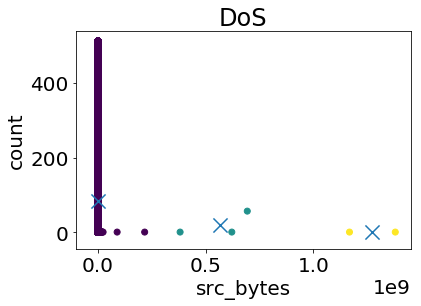

In [4]:
k_mean(3, kddDF[['src_bytes','count']], "DoS")

In [ ]:
k_mean3D(3, kddDF[["count", "src_bytes", "duration"]], "DoS")

In [ ]:
k_mean(3, kddDF[["duration","src_bytes"]], "Probing", "Duration (s)")

In [ ]:
k_mean(3, kddDF[['num_file_creations', 'num_shells']], "U2R")

In [ ]:
k_mean3D(3,  kddDF[['num_file_creations', 'num_shells', 'duration']], "U2R", zLabel='Duration (s)')

In [ ]:
k_mean(3, kddDF[['duration', 'num_failed_logins']], "R2L", "Duration (s)")

<u><strong>Performing K-NN</strong></u>

In [ ]:
k_nn(kddDF[['src_bytes','count', 'Class']], "src_bytes", "Class", "DoS")

In [ ]:
k_nn(kddDF[["duration","src_bytes", 'Class']], "src_bytes", "Class", "Probing")

In [ ]:
k_nn(kddDF[['num_file_creations', 'num_shells', 'Class']], "num_shells", "Class", "U2R")

In [ ]:
k_nn(kddDF[['duration', 'num_failed_logins', 'Class']], "num_failed_logins", "Class", "R2L")

<u><strong>Swarm Plot</strong></u>

In [ ]:
swarm_all(kddDF[['duration','Class']][:500], "Class", "Swarm plot of duration")

# CIDDS Dataset

<u><strong>Load CIDDS Dataset</strong></u>

In [ ]:
ciddsDF = pd.read_csv("CIDDS-001-internal-week1.csv", low_memory=False)
ciddsDF.head()

In [ ]:
feats = ["Src Pt", "Dst Pt", "Packets", "Flows"]

<u><strong>Finding K</strong></u>

In [ ]:
find_k_graph(5, ciddsDF[["Src Pt", "Packets"]])

<u><strong>Performing K-mean</strong></u>

In [ ]:
k_mean(2, ciddsDF[["Src Pt", "Packets"]], "DoS")

In [ ]:
# k_mean(4, ciddsDF[["Src Pt", "Packets"]], "K-Mean cluster on CIDDS Dataset")

In [ ]:
k_nn(ciddsDF[['Src Pt','Packets', 'class']], "Src Pt", "Class", "DoS")

In [ ]:
swarm_all(ciddsDF[['duration', 'Src Pt', 'Dest Pt', 'Packets', 'Bytes', 'Flows', 'Tos' 'class']][:500], "Class", "Swarm plot of duration")